In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error

#This section of code has all of the data import, merging, and initial setup.

test_data_split = 231  #this will be the number of weeks in the test data set, remainder of data in train data set
#Calculate the split date to use
split_date = datetime.now() - timedelta(weeks=test_data_split) 
print('Split Date: {0}'.format(split_date))

#Read in the transportation data, monthly seasonally adjusted
tsi_data = pd.read_excel(".\data\Input_SeasonalData_TSI.xlsx", header=2)

#Read in the real gdp growth rates,seasonally adjusted, quarterly data with quarterly growth rates
gdp_data = pd.read_excel(".\data\Input_GDP_st_louis_fed_quarterly_change.xlsx")

#Merge the 2 datasets together based on the date. 
merged_data = pd.merge(tsi_data, gdp_data, how='left', left_on='OBS_DATE', right_on='observation_date')

#We now have 2 date columns.  Drop the date column from the gdp_data dataframe.
merged_data = merged_data.drop(['observation_date'], axis=1) #pandas can drop rows or columns, axis=1 indicates columns

#Forward fill the gdp data so that a quarterly gdp value will be used for 3 rows, with each row being a month.
#limit it only fill in 2 consective missing values.
merged_data['Real_gdp_qtr_growth'] = merged_data['Real_gdp_qtr_growth'].fillna(method='ffill', limit=2)

#drop rows where we don't have a gdp value
merged_data = merged_data.dropna(subset=['Real_gdp_qtr_growth'])

#Create a boolean column to indicate if gdp growth was positive or negative.
merged_data['gdp_is_increasing'] = merged_data.apply(lambda x: True if x['Real_gdp_qtr_growth'] > 0.0 else False, axis=1)

merged_data['RAIL_FRT_PCT'] = merged_data['RAIL_FRT_CARLOADS_D11'].pct_change()*100.0
merged_data['RAIL_INTERMOD_PCT'] = merged_data['RAIL_FRT_INTERMODAL_D11'].pct_change()*100.0
merged_data['WATERBORNE_PCT'] = merged_data['WATERBORNE_D11'].pct_change()*100.0
merged_data['TRUCK_PCT'] = merged_data['TRUCK_D11'].pct_change()*100.0
merged_data['AIR_RTMFM_PCT'] = merged_data['AIR_RTMFM_D11'].pct_change()*100.0
merged_data['TSI_PCT'] = merged_data['TSI'].pct_change()*100.0

#create x_train and y_train dataframes
x_train = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'RAIL_FRT_PCT':'TSI_PCT']
x_train.drop([0], inplace=True) #drop first row as it will have NA for pct_change values
y_train_class = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'gdp_is_increasing'] #ydata for classifier models
y_train_class.drop([0], inplace=True) #drop first row as it will have NA for pct_change values
y_train_rate = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'Real_gdp_qtr_growth'] #y data for regression models
y_train_rate.drop([0], inplace=True) #drop first row as it will have NA for pct_change values

print('x_train row count: {0}'.format(len(x_train.index)))
print('y_train_class row count: {0}'.format(len(y_train_class.index)))
print('y_train_rate row count: {0}'.format(len(y_train_rate.index)))

x_test = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'RAIL_FRT_PCT':'TSI_PCT']
y_test_class = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'gdp_is_increasing']
y_test_rate = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'Real_gdp_qtr_growth']

print('x_test row count: {0}'.format(len(x_test.index)))
print('y_test_class row count: {0}'.format(len(y_test_class.index)))
print('y_test_rate row count: {0}'.format(len(y_test_rate.index)))

Split Date: 2015-12-03 18:31:29.456873
x_train row count: 191
y_train_class row count: 191
y_train_rate row count: 191
x_test row count: 48
y_test_class row count: 48
y_test_rate row count: 48


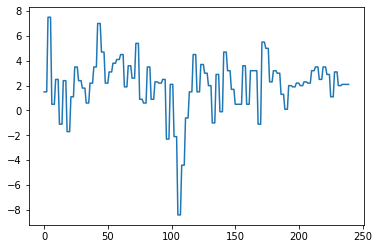

In [2]:
import matplotlib.pyplot as plt

plt.plot(merged_data['Real_gdp_qtr_growth'])

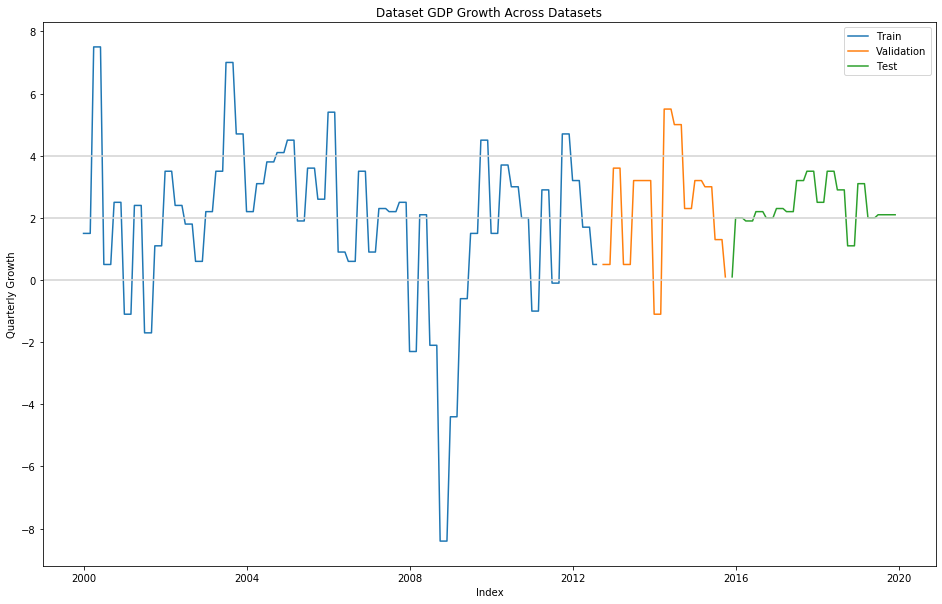

In [3]:
plt.plot(merged_data.iloc[:152]['OBS_DATE'], merged_data.iloc[:152]['Real_gdp_qtr_growth'], Label="Train")
plt.plot(merged_data.iloc[153:190]['OBS_DATE'], merged_data.iloc[153:190]['Real_gdp_qtr_growth'], Label="Validation")
plt.plot(merged_data.iloc[191:]['OBS_DATE'], merged_data.iloc[191:]['Real_gdp_qtr_growth'], Label="Test")
plt.title('Dataset GDP Growth Across Datasets')
plt.ylabel('Quarterly Growth')
plt.xlabel('Index')
#plt.xticks(np.arange(2000, 2020,step=2))
plt.legend()
plt.axhline(0, 0, 250, c='lightgrey')
plt.axhline(2, 0, 250, c='lightgrey')
plt.axhline(4, 0, 250, c='lightgrey')
fig = plt.gcf()
fig.set_size_inches(16,10)
#merged_data

In [4]:
y_train_std = merged_data.iloc[:152]['Real_gdp_qtr_growth'].std(axis=0)
print('y_train_std: {0:0.2f}'.format(y_train_std))

y_val_std = merged_data.iloc[153:190]['Real_gdp_qtr_growth'].std(axis=0)
print('y_val_std: {0:0.2f}'.format(y_val_std))

y_test_std = merged_data.iloc[191:]['Real_gdp_qtr_growth'].std(axis=0)
print('y_test_std: {0:0.2f}'.format(y_test_std))


y_train_std: 2.67
y_val_std: 1.88
y_test_std: 0.72


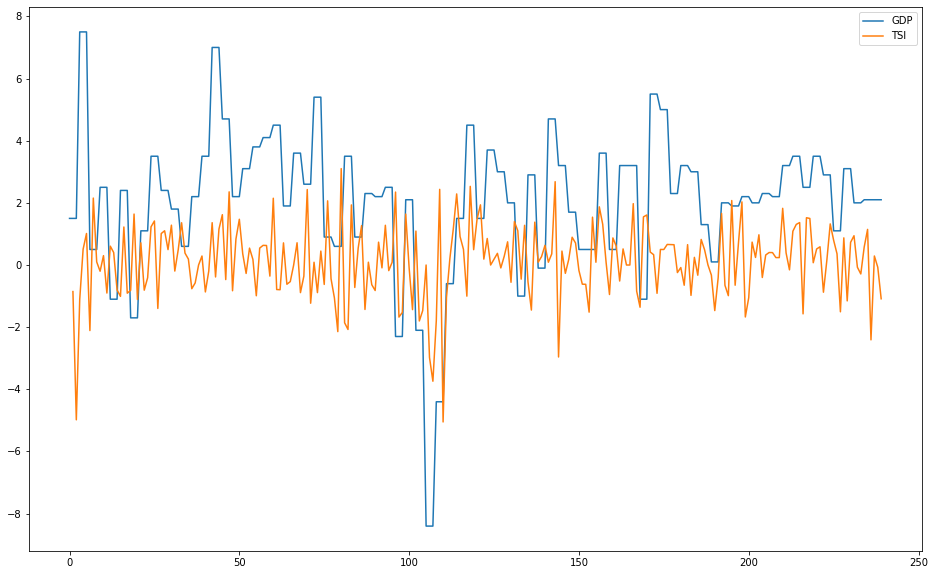

In [5]:
from matplotlib.pyplot import figure
#plt.plot(merged_data['RAIL_FRT_PCT'], label='Rail Frt')
plt.plot(merged_data['Real_gdp_qtr_growth'], label='GDP')
#plt.plot(merged_data['RAIL_INTERMOD_PCT'], label='Rail Intermod')
#plt.plot(merged_data['WATERBORNE_PCT'], label='Water')
#plt.plot(merged_data['TRUCK_PCT'], label='Truck')
#plt.plot(merged_data['AIR_RTMFM_PCT'], label='Air and Mail Frt')
plt.plot(merged_data['TSI_PCT'], label='TSI')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(16,10)

In [6]:
railcorr = np.corrcoef(x_train['RAIL_FRT_PCT'], y_train_rate)
print('Rail Frt Corr: {0:0.2f}'.format(railcorr[0,1]))

railimodcorr = np.corrcoef(x_train['RAIL_INTERMOD_PCT'], y_train_rate)
print('Rail Intermod Corr: {0:0.2f}'.format(railimodcorr[0,1]))

watercorr = np.corrcoef(x_train['WATERBORNE_PCT'], y_train_rate)
print('Water Corr: {0:0.2f}'.format(watercorr[0,1]))

truckcorr = np.corrcoef(x_train['TRUCK_PCT'], y_train_rate)
print('Truck Corr: {0:0.2f}'.format(truckcorr[0,1]))

aircorr = np.corrcoef(x_train['AIR_RTMFM_PCT'], y_train_rate)
print('Air and Mail Frt Corr: {0:0.2f}'.format(aircorr[0,1]))

tsicorr = np.corrcoef(x_train['TSI_PCT'], y_train_rate)
print('TSI Corr: {0:0.2f}'.format(tsicorr[0,1]))


Rail Frt Corr: 0.13
Rail Intermod Corr: 0.21
Water Corr: 0.02
Truck Corr: 0.18
Air and Mail Frt Corr: 0.19
TSI Corr: 0.23


In [7]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train_std = x_train - mean
x_train_std = x_train / std

x_test_std = x_test - mean
x_test_std = x_test / std

In [8]:
#x_train_std.shape[1,]
x_trainstdnp = x_train_std.to_numpy()
x_trainstdnp.shape

(191, 6)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense , Lambda #,Dropout ,  Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
#import tensorflow as tf

def get_nn_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(1,)),
        BatchNormalization(),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model        

In [ ]:
model=get_nn_model()
model.optimizer.lr=0.001
#history=model.fit(x=x_train_std.iloc[:153]['TSI_PCT'], y=y_train_rate.iloc[:153], epochs=500)#, validation_split=0.2) # shuffle=True) #, batch_size=5)
history=model.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2) # shuffle=True) #, batch_size=5)

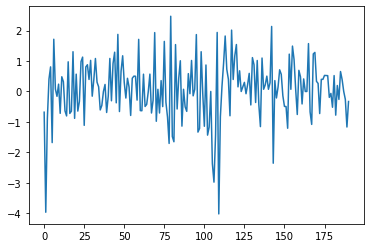

In [9]:
#x_train
plt.plot(x_train_std['TSI_PCT'].to_numpy(), Label="x_train")

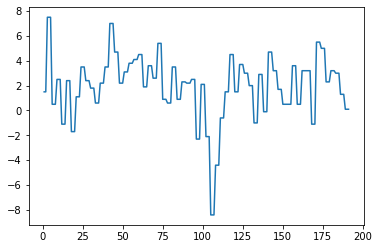

In [10]:
plt.plot(y_train_rate, Label="y_train_rate")

In [ ]:
predictions_test = model.predict(x_test_std['TSI_PCT'])

test_mean_abs_error = mean_absolute_error(y_test_rate, predictions_test)
print('Test mean abs error: {0:0.2f}'.format(test_mean_abs_error))

In [ ]:
predictions_test.transpose()

In [ ]:
y_test_rate.to_numpy()

In [ ]:
plt.plot(predictions_test, label='Test Predictions')
plt.plot(y_test_rate.index - 191, y_test_rate, label='Actual') #the dataframe has its index from the data split
plt.legend()

In [ ]:
# Plot history: MAE
plt.plot(history.history['mean_absolute_error'], label='MAE (training data)')
plt.plot(history.history['val_mean_absolute_error'], label='MAE (validation data)')
plt.title('MAE for GDP Neural Network Regression Predictor')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [ ]:
# Plot history: MSE
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('MSE for GDP Neural Network Regression Predictor')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [44]:
from keras import regularizers
from keras import models
from keras import layers

def get_nn_model_regularization(penalty, reg_type="L2", dense_layers=16):
    model_regn = models.Sequential()
    
    if reg_type == "L2":
        model_regn.add(layers.Dense(dense_layers, activation='relu', input_shape=(1,), kernel_regularizer=regularizers.l2(penalty)))
    else:
        model_regn.add(layers.Dense(dense_layers, activation='relu', input_shape=(1,), kernel_regularizer=regularizers.l1(penalty)))
        
    model_regn.add(layers.BatchNormalization())

    if reg_type == "L2":
        model_regn.add(layers.Dense(dense_layers, activation='relu', input_shape=(1,), kernel_regularizer=regularizers.l2(penalty)))
    else:
        model_regn.add(layers.Dense(dense_layers, activation='relu', input_shape=(1,), kernel_regularizer=regularizers.l1(penalty)))

    model_regn.add(layers.BatchNormalization())
    model_regn.add(layers.Dense(1, activation='linear'))
    
    model_regn.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model_regn 

In [45]:
model_reg = get_nn_model_regularization(penalty=0.001)
model_reg.optimizer.lr = 0.001 #0.005
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2)

Train on 152 samples, validate on 39 samples
Epoch 1/500
152/152 [==============================] - 12s 78ms/step - loss: 16.1873 - mean_absolute_error: 3.3345 - val_loss: 12.6392 - val_mean_absolute_error: 3.0488
Epoch 2/500
152/152 [==============================] - 0s 296us/step - loss: 13.9474 - mean_absolute_error: 3.0816 - val_loss: 12.2372 - val_mean_absolute_error: 3.0013
Epoch 3/500
152/152 [==============================] - 0s 257us/step - loss: 12.8534 - mean_absolute_error: 2.9621 - val_loss: 11.8888 - val_mean_absolute_error: 2.9528
Epoch 4/500
152/152 [==============================] - 0s 289us/step - loss: 12.4821 - mean_absolute_error: 2.9209 - val_loss: 11.4614 - val_mean_absolute_error: 2.9045
Epoch 5/500
152/152 [==============================] - 0s 276us/step - loss: 11.4148 - mean_absolute_error: 2.7980 - val_loss: 11.0210 - val_mean_absolute_error: 2.8442
Epoch 6/500
152/152 [==============================] - 0s 204us/step - loss: 10.9682 - mean_absolute_error: 2.

152/152 [==============================] - 0s 171us/step - loss: 6.5631 - mean_absolute_error: 1.9653 - val_loss: 3.5908 - val_mean_absolute_error: 1.5999
Epoch 50/500
152/152 [==============================] - 0s 171us/step - loss: 6.4846 - mean_absolute_error: 1.9516 - val_loss: 3.5420 - val_mean_absolute_error: 1.6020
Epoch 51/500
152/152 [==============================] - 0s 178us/step - loss: 6.3557 - mean_absolute_error: 1.9245 - val_loss: 3.6141 - val_mean_absolute_error: 1.6254
Epoch 52/500
152/152 [==============================] - 0s 171us/step - loss: 6.3919 - mean_absolute_error: 1.9239 - val_loss: 3.6799 - val_mean_absolute_error: 1.6440
Epoch 53/500
152/152 [==============================] - 0s 151us/step - loss: 6.3812 - mean_absolute_error: 1.9190 - val_loss: 3.7520 - val_mean_absolute_error: 1.6581
Epoch 54/500
152/152 [==============================] - 0s 191us/step - loss: 6.2942 - mean_absolute_error: 1.9482 - val_loss: 3.6750 - val_mean_absolute_error: 1.6320
Epoch

152/152 [==============================] - 0s 250us/step - loss: 6.2160 - mean_absolute_error: 1.8416 - val_loss: 3.4657 - val_mean_absolute_error: 1.5938
Epoch 98/500
152/152 [==============================] - 0s 355us/step - loss: 5.9264 - mean_absolute_error: 1.8167 - val_loss: 3.5570 - val_mean_absolute_error: 1.6136
Epoch 99/500
152/152 [==============================] - 0s 250us/step - loss: 5.9009 - mean_absolute_error: 1.8041 - val_loss: 3.5853 - val_mean_absolute_error: 1.6195
Epoch 100/500
152/152 [==============================] - 0s 257us/step - loss: 5.9014 - mean_absolute_error: 1.8085 - val_loss: 3.5543 - val_mean_absolute_error: 1.6109
Epoch 101/500
152/152 [==============================] - 0s 204us/step - loss: 6.2614 - mean_absolute_error: 1.8628 - val_loss: 3.4630 - val_mean_absolute_error: 1.5909
Epoch 102/500
152/152 [==============================] - 0s 263us/step - loss: 6.0077 - mean_absolute_error: 1.8233 - val_loss: 3.4563 - val_mean_absolute_error: 1.5935
Ep

152/152 [==============================] - 0s 296us/step - loss: 5.9639 - mean_absolute_error: 1.8209 - val_loss: 3.2091 - val_mean_absolute_error: 1.5303
Epoch 146/500
152/152 [==============================] - 0s 388us/step - loss: 6.2112 - mean_absolute_error: 1.8552 - val_loss: 3.2541 - val_mean_absolute_error: 1.5437
Epoch 147/500
152/152 [==============================] - 0s 270us/step - loss: 5.7821 - mean_absolute_error: 1.7985 - val_loss: 3.2660 - val_mean_absolute_error: 1.5468
Epoch 148/500
152/152 [==============================] - 0s 250us/step - loss: 5.9711 - mean_absolute_error: 1.8309 - val_loss: 3.3702 - val_mean_absolute_error: 1.5694
Epoch 149/500
152/152 [==============================] - 0s 211us/step - loss: 5.7531 - mean_absolute_error: 1.7964 - val_loss: 3.4437 - val_mean_absolute_error: 1.5912
Epoch 150/500
152/152 [==============================] - 0s 283us/step - loss: 6.1321 - mean_absolute_error: 1.8505 - val_loss: 3.4214 - val_mean_absolute_error: 1.5881


152/152 [==============================] - 0s 197us/step - loss: 5.8287 - mean_absolute_error: 1.8029 - val_loss: 3.4036 - val_mean_absolute_error: 1.5708
Epoch 194/500
152/152 [==============================] - 0s 184us/step - loss: 5.9801 - mean_absolute_error: 1.8360 - val_loss: 3.4250 - val_mean_absolute_error: 1.5842
Epoch 195/500
152/152 [==============================] - 0s 164us/step - loss: 5.9212 - mean_absolute_error: 1.8415 - val_loss: 3.4454 - val_mean_absolute_error: 1.5962
Epoch 196/500
152/152 [==============================] - 0s 164us/step - loss: 6.1124 - mean_absolute_error: 1.8277 - val_loss: 3.4422 - val_mean_absolute_error: 1.5980
Epoch 197/500
152/152 [==============================] - 0s 164us/step - loss: 6.3668 - mean_absolute_error: 1.8678 - val_loss: 3.4053 - val_mean_absolute_error: 1.5879
Epoch 198/500
152/152 [==============================] - 0s 250us/step - loss: 6.0775 - mean_absolute_error: 1.8257 - val_loss: 3.3602 - val_mean_absolute_error: 1.5755


152/152 [==============================] - 0s 296us/step - loss: 6.0136 - mean_absolute_error: 1.8113 - val_loss: 3.2622 - val_mean_absolute_error: 1.5466
Epoch 242/500
152/152 [==============================] - 0s 296us/step - loss: 6.0673 - mean_absolute_error: 1.8159 - val_loss: 3.1330 - val_mean_absolute_error: 1.5117
Epoch 243/500
152/152 [==============================] - 0s 211us/step - loss: 6.0518 - mean_absolute_error: 1.8349 - val_loss: 3.2472 - val_mean_absolute_error: 1.5426
Epoch 244/500
152/152 [==============================] - 0s 211us/step - loss: 6.0144 - mean_absolute_error: 1.7884 - val_loss: 3.2975 - val_mean_absolute_error: 1.5554
Epoch 245/500
152/152 [==============================] - 0s 211us/step - loss: 5.9789 - mean_absolute_error: 1.7846 - val_loss: 3.1642 - val_mean_absolute_error: 1.5160
Epoch 246/500
152/152 [==============================] - 0s 171us/step - loss: 6.1447 - mean_absolute_error: 1.8554 - val_loss: 3.1485 - val_mean_absolute_error: 1.5028


152/152 [==============================] - 0s 178us/step - loss: 5.8467 - mean_absolute_error: 1.7910 - val_loss: 3.2399 - val_mean_absolute_error: 1.5463
Epoch 290/500
152/152 [==============================] - 0s 184us/step - loss: 6.0163 - mean_absolute_error: 1.8112 - val_loss: 3.2600 - val_mean_absolute_error: 1.5293
Epoch 291/500
152/152 [==============================] - 0s 164us/step - loss: 5.9835 - mean_absolute_error: 1.8379 - val_loss: 3.2503 - val_mean_absolute_error: 1.5272
Epoch 292/500
152/152 [==============================] - 0s 164us/step - loss: 5.7644 - mean_absolute_error: 1.7978 - val_loss: 3.2656 - val_mean_absolute_error: 1.5384
Epoch 293/500
152/152 [==============================] - 0s 158us/step - loss: 6.0766 - mean_absolute_error: 1.8322 - val_loss: 3.3016 - val_mean_absolute_error: 1.5583
Epoch 294/500
152/152 [==============================] - 0s 184us/step - loss: 6.2026 - mean_absolute_error: 1.8574 - val_loss: 3.3640 - val_mean_absolute_error: 1.5651


152/152 [==============================] - 0s 296us/step - loss: 5.9193 - mean_absolute_error: 1.7940 - val_loss: 3.4936 - val_mean_absolute_error: 1.6045
Epoch 338/500
152/152 [==============================] - 0s 342us/step - loss: 5.9126 - mean_absolute_error: 1.7788 - val_loss: 3.2627 - val_mean_absolute_error: 1.5597
Epoch 339/500
152/152 [==============================] - 0s 217us/step - loss: 5.8670 - mean_absolute_error: 1.7821 - val_loss: 3.2069 - val_mean_absolute_error: 1.5476
Epoch 340/500
152/152 [==============================] - 0s 224us/step - loss: 5.9548 - mean_absolute_error: 1.8171 - val_loss: 3.2397 - val_mean_absolute_error: 1.5546
Epoch 341/500
152/152 [==============================] - 0s 289us/step - loss: 5.9639 - mean_absolute_error: 1.8127 - val_loss: 3.2377 - val_mean_absolute_error: 1.5536
Epoch 342/500
152/152 [==============================] - 0s 211us/step - loss: 5.8607 - mean_absolute_error: 1.8061 - val_loss: 3.2870 - val_mean_absolute_error: 1.5590


152/152 [==============================] - 0s 230us/step - loss: 6.0590 - mean_absolute_error: 1.8028 - val_loss: 3.2469 - val_mean_absolute_error: 1.5478
Epoch 386/500
152/152 [==============================] - 0s 171us/step - loss: 5.9854 - mean_absolute_error: 1.8238 - val_loss: 3.2251 - val_mean_absolute_error: 1.5433
Epoch 387/500
152/152 [==============================] - 0s 164us/step - loss: 5.9260 - mean_absolute_error: 1.7947 - val_loss: 3.2555 - val_mean_absolute_error: 1.5517
Epoch 388/500
152/152 [==============================] - 0s 164us/step - loss: 5.9437 - mean_absolute_error: 1.7996 - val_loss: 3.3168 - val_mean_absolute_error: 1.5616
Epoch 389/500
152/152 [==============================] - 0s 164us/step - loss: 6.1934 - mean_absolute_error: 1.8257 - val_loss: 3.2894 - val_mean_absolute_error: 1.5570
Epoch 390/500
152/152 [==============================] - 0s 178us/step - loss: 5.6955 - mean_absolute_error: 1.7747 - val_loss: 3.2644 - val_mean_absolute_error: 1.5463


152/152 [==============================] - 0s 230us/step - loss: 5.9992 - mean_absolute_error: 1.8260 - val_loss: 3.3351 - val_mean_absolute_error: 1.5528
Epoch 434/500
152/152 [==============================] - 0s 276us/step - loss: 6.0064 - mean_absolute_error: 1.8271 - val_loss: 3.2907 - val_mean_absolute_error: 1.5454
Epoch 435/500
152/152 [==============================] - 0s 309us/step - loss: 5.8812 - mean_absolute_error: 1.8054 - val_loss: 3.2601 - val_mean_absolute_error: 1.5543
Epoch 436/500
152/152 [==============================] - 0s 322us/step - loss: 5.8023 - mean_absolute_error: 1.7769 - val_loss: 3.3198 - val_mean_absolute_error: 1.5612
Epoch 437/500
152/152 [==============================] - 0s 322us/step - loss: 5.7328 - mean_absolute_error: 1.7812 - val_loss: 3.3099 - val_mean_absolute_error: 1.5566
Epoch 438/500
152/152 [==============================] - 0s 283us/step - loss: 5.9700 - mean_absolute_error: 1.8043 - val_loss: 3.2643 - val_mean_absolute_error: 1.5467


152/152 [==============================] - 0s 184us/step - loss: 6.0632 - mean_absolute_error: 1.8383 - val_loss: 3.1767 - val_mean_absolute_error: 1.5248
Epoch 482/500
152/152 [==============================] - 0s 178us/step - loss: 5.7853 - mean_absolute_error: 1.7999 - val_loss: 3.2431 - val_mean_absolute_error: 1.5366
Epoch 483/500
152/152 [==============================] - 0s 171us/step - loss: 6.0332 - mean_absolute_error: 1.8202 - val_loss: 3.3180 - val_mean_absolute_error: 1.5500
Epoch 484/500
152/152 [==============================] - 0s 184us/step - loss: 5.8684 - mean_absolute_error: 1.8107 - val_loss: 3.3223 - val_mean_absolute_error: 1.5475
Epoch 485/500
152/152 [==============================] - 0s 164us/step - loss: 5.9546 - mean_absolute_error: 1.8158 - val_loss: 3.3624 - val_mean_absolute_error: 1.5488
Epoch 486/500
152/152 [==============================] - 0s 164us/step - loss: 6.0708 - mean_absolute_error: 1.8268 - val_loss: 3.2795 - val_mean_absolute_error: 1.5318


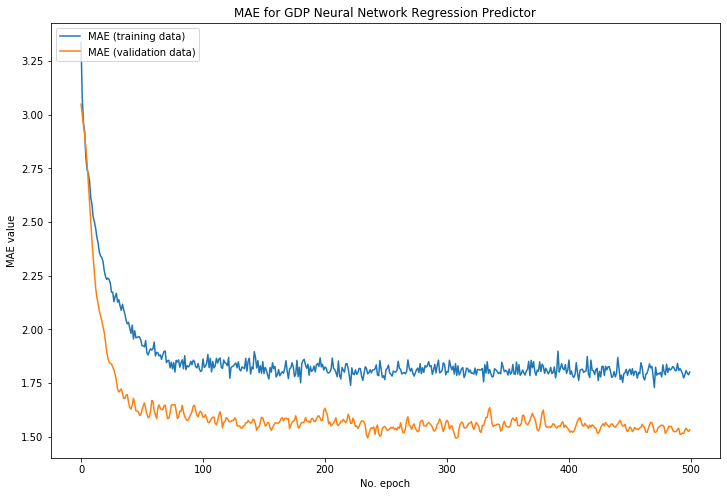

In [46]:
# Plot history: MAE
plt.plot(history_reg.history['mean_absolute_error'], label='MAE (training data)')
plt.plot(history_reg.history['val_mean_absolute_error'], label='MAE (validation data)')
plt.title('MAE for GDP Neural Network Regression Predictor')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [ ]:
predictions_test_reg = model_reg.predict(x_test_std['TSI_PCT'])

test_mean_abs_error_reg = mean_absolute_error(y_test_rate, predictions_test_reg)
print('Test mean abs error with regularization: {0:0.2f}'.format(test_mean_abs_error_reg))

In [ ]:
training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}'.format(val_mae_history))

In [15]:
#results = []
results = pd.DataFrame(columns=['Desc','Penalty', 'Reg Type', 'Dense Layers', 'Learning Rate', 'Training MAE Mean', 
                                'Training MAE Min', 'Val MAE Mean', 'Val MAE Min'])
for in_dense_layers in [16, 32, 64]:
    for in_reg_type in ["L1", "L2"]:
        for in_penalty in [0.1, 0.01, 0.001]:
            for in_learning_rate in [0.01, 0.001, 0.0006]:
                testcase = 'penalty={0:0.03f}, reg={1}, dense_layers={2}, lr={3:0.4f}'.format(in_penalty, in_reg_type, in_dense_layers, in_learning_rate)
                print(testcase)
                model_reg = get_nn_model_regularization(penalty=in_penalty, reg_type=in_reg_type, dense_layers=in_dense_layers)
                model_reg.optimizer.lr = in_learning_rate
                history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

                training_mae_mean = np.mean(history_reg.history['mean_absolute_error'][450:500])
                training_mae_min = np.min(history_reg.history['mean_absolute_error'])
                val_mae_mean = np.mean(history_reg.history['val_mean_absolute_error'][450:500])
                val_mae_min = np.min(history_reg.history['val_mean_absolute_error'])
                print('Training mean abs error: {0:0.2f}'.format(training_mae_mean))
                print('Val mean abs error: {0:0.2f}\n'.format(val_mae_mean))
                #results.append((testcase, training_mae_mean, training_mae_min, val_mae_mean, val_mae_min))
                results = results.append(pd.Series([testcase, in_penalty, in_reg_type, in_dense_layers, in_learning_rate,
                                                   training_mae_mean, training_mae_min, val_mae_mean, val_mae_min], index=results.columns ), ignore_index=True)
                

penalty=0.100, reg=L1, dense_layers=16, lr=0.0100
Training mean abs error: 1.81
Val mean abs error: 1.55

penalty=0.100, reg=L1, dense_layers=16, lr=0.0010
Training mean abs error: 1.83
Val mean abs error: 1.56

penalty=0.100, reg=L1, dense_layers=16, lr=0.0006
Training mean abs error: 1.82
Val mean abs error: 1.55

penalty=0.010, reg=L1, dense_layers=16, lr=0.0100
Training mean abs error: 1.82
Val mean abs error: 1.53

penalty=0.010, reg=L1, dense_layers=16, lr=0.0010
Training mean abs error: 1.81
Val mean abs error: 1.60

penalty=0.010, reg=L1, dense_layers=16, lr=0.0006
Training mean abs error: 1.83
Val mean abs error: 1.54

penalty=0.001, reg=L1, dense_layers=16, lr=0.0100
Training mean abs error: 1.82
Val mean abs error: 1.54

penalty=0.001, reg=L1, dense_layers=16, lr=0.0010
Training mean abs error: 1.81
Val mean abs error: 1.56

penalty=0.001, reg=L1, dense_layers=16, lr=0.0006
Training mean abs error: 1.82
Val mean abs error: 1.56

penalty=0.100, reg=L2, dense_layers=16, lr=0.0

In [21]:
results.sort_values('Val MAE Mean', inplace=True)

In [ ]:
results['Desc']

In [16]:
results.to_excel('gdp_output_20200507.xlsx')

In [ ]:
history_reg.history['mean_absolute_error']

In [ ]:
results = pd.DataFrame(columns=['Desc','Penalty', 'Reg Type', 'Dense Layers', 'Learning Rate'])

In [ ]:
results.append([['test', '0', 'L1', '16', '.01']], ignore_index=True)

In [22]:
results

,Desc,Penalty,Reg Type,Dense Layers,Learning Rate,Training MAE Mean,Training MAE Min,Val MAE Mean,Val MAE Min
17,"penalty=0.001, reg=L2, dense_layers=16, lr=0.0006",0.001,L2,16,0.0006,1.815280,1.772364,1.509492,1.425177
51,"penalty=0.001, reg=L2, dense_layers=64, lr=0.0100",0.001,L2,64,0.0100,1.810756,1.737322,1.515320,1.429249
15,"penalty=0.001, reg=L2, dense_layers=16, lr=0.0100",0.001,L2,16,0.0100,1.810244,1.732582,1.517287,1.436291
52,"penalty=0.001, reg=L2, dense_layers=64, lr=0.0010",0.001,L2,64,0.0010,1.810183,1.766197,1.523972,1.464010
3,"penalty=0.010, reg=L1, dense_layers=16, lr=0.0100",0.010,L1,16,0.0100,1.816824,1.754844,1.528912,1.404433
30,"penalty=0.010, reg=L2, dense_layers=32, lr=0.0100",0.010,L2,32,0.0100,1.810228,1.720215,1.532599,1.449507
37,"penalty=0.100, reg=L1, dense_layers=64, lr=0.0010",0.100,L1,64,0.0010,1.808077,1.758049,1.533433,1.459378
6,"penalty=0.001, reg=L1, dense_layers=16, lr=0.0100",0.001,L1,16,0.0100,1.819699,1.719124,1.535099,1.474751
22,"penalty=0.010, reg=L1, dense_layers=32, lr=0.0010",0.010,L1,32,0.0010,1.809178,1.745712,1.536508,1.446214
5,"penalty=0.010, reg=L1, dense_layers=16, lr=0.0006",0.010,L1,16,0.0006,1.828186,1.776252,1.540857,1.506211


In [ ]:
results = results.append(pd.Series(['test', 0.02, 'L1', 32, 0.01], index=results.columns ), ignore_index=True)

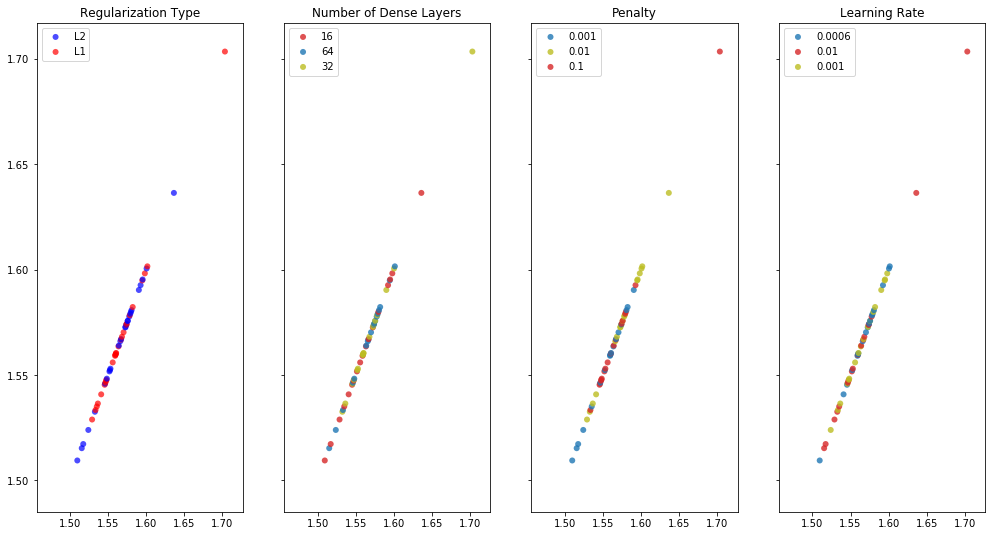

In [43]:
regcolors = ("red", "blue")
regtype = ("L1", "L2") 

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)

for ind in results.index:
    regtype_val = results['Reg Type'][ind]
    axs[0].scatter(results['Val MAE Mean'][ind], results['Val MAE Mean'][ind], 
               c=regcolors[regtype.index(regtype_val)],
               label=regtype_val, alpha=0.7, edgecolors='none')

handles, labels = axs[0].get_legend_handles_labels() #This section of code builds a
by_label = dict(zip(labels, handles))           #unique list of the labels and then uses 
axs[0].legend(by_label.values(), by_label.keys())  #them to build the legend. This is neccessary to
axs[0].set_title('Regularization Type')            #prevent duplicated labels in the legend.
    
densecolors = ("tab:red", "tab:olive", "tab:blue")
densetype = (16, 32, 64)
for ind in results.index:
    densetype_val = results['Dense Layers'][ind]
    #print(densetype_val)
    axs[1].scatter(results['Val MAE Mean'][ind], results['Val MAE Mean'][ind], 
               c=densecolors[densetype.index(densetype_val)], 
               label=densetype_val, alpha=0.8, edgecolors='none')
    
handles, labels = axs[1].get_legend_handles_labels() #This section of code builds a
by_label = dict(zip(labels, handles))           #unique list of the labels and then uses 
axs[1].legend(by_label.values(), by_label.keys())  #them to build the legend. This is neccessary to
                                               #prevent duplicated labels in the legend.
#https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
axs[1].set_title('Number of Dense Layers')

#Penalty
penaltycolors = ("tab:red", "tab:olive", "tab:blue")       
penaltytype = (0.1, 0.01, 0.001)
for ind in results.index:
    penaltytype_val = results['Penalty'][ind]
    axs[2].scatter(results['Val MAE Mean'][ind], results['Val MAE Mean'][ind],
                   c=penaltycolors[penaltytype.index(penaltytype_val)],
                   label=penaltytype_val, alpha=0.8, edgecolors='none')

handles, labels = axs[2].get_legend_handles_labels() #This section of code builds a
by_label = dict(zip(labels, handles))           #unique list of the labels and then uses 
axs[2].legend(by_label.values(), by_label.keys())  #them to build the legend. This is neccessary to
                                               #prevent duplicated labels in the legend.
axs[2].set_title('Penalty')

#learninr Rate
# for in_learning_rate in [0.01, 0.001, 0.0006]
learnratecolors = ("tab:red", "tab:olive", "tab:blue")       
learnratetype = (0.01, 0.001, 0.0006)
for ind in results.index:
    learnratetype_val = results['Learning Rate'][ind]
    axs[3].scatter(results['Val MAE Mean'][ind], results['Val MAE Mean'][ind],
                   c=learnratecolors[learnratetype.index(learnratetype_val)],
                   label=learnratetype_val, alpha=0.8, edgecolors='none')

handles, labels = axs[3].get_legend_handles_labels() #This section of code builds a
by_label = dict(zip(labels, handles))           #unique list of the labels and then uses 
axs[3].legend(by_label.values(), by_label.keys())  #them to build the legend. This is neccessary to
                                               #prevent duplicated labels in the legend.
axs[3].set_title('Learning Rate')
    
#ax.legend(loc="upper left")
#fig = plt.gcf()
fig.set_size_inches(17,9)
#plt.show()

Based on the above charts and from looking at the data, it seems like:
-  Reg Type = L2
-  Dense Layers = 16
-  Penalty = 0.001
-  Learning Rate = 0.001